Date: 04/14/2025

Author: Mercy Amankwah

Purpose: Feature importance for AdaBoost and XGBoost models on entire dataset 

In this notebook, we perform feature analysis on the scenario where we use the entire dataset, i.e. all features.  The main model considered is the optimized Adaboost model obtained when we tuned using ``optuna``.  For completion we also consider the optimized XGBoost model as well. 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
## Reading the traning and testing datasets
df = pd.read_csv("../data/kaggle_train.csv")

## Dropping redundant columns
df = df.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_train, df_test = train_test_split(df, random_state= 123 , shuffle= True,
                                     test_size=0.2, stratify=df['Diagnosis'])

In [3]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


In [4]:
# Define colors for feature categories
category_colors = {
    "Demographics": "green",
    "Lifestyle": "orange",
    "Medical History": "blue",
    "Clinical Measurements": "purple",
    "Cognitive Assesments": "pink",
    "Symptoms": "yellow"  
}

# Mapping features to their categories
feature_categories = {
    **{feature: "Demographics" for feature in demo_features},
    **{feature: "Lifestyle" for feature in life_style_features},
    **{feature: "Medical History" for feature in medic_hist_features},
    **{feature: "Clinical Measurements" for feature in clinical_features},
    **{feature: "Cognitive Assesments" for feature in cognitive_features}
}

## **Tuned Adaboost model**

I'm choosing the set of best parameters corresponding to the tuned model resulting from **optimizing precision** as those produced the best scores across all 4 metrics for the different studies in the optuna

In [5]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 2,
    'min_samples_split': 19
}
model_tuned_ada_params = {
    'n_estimators': 130,
    'learning_rate': 0.26971280658002783,
    'algorithm': 'SAMME.R'
}

##### **Feature Importance for Adaboost model**

In [6]:
# Tuned AdaBoost model for the entire dataset
model0 = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)
model0.fit(df_train[all_features[:-1]],df_train.Diagnosis)

c:\Users\ladyj\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=2,
                                                    min_samples_split=19,
                                                    random_state=123),
                   learning_rate=0.26971280658002783, n_estimators=130,
                   random_state=123)

In [7]:
#Compute feature important scores
importances = model0.feature_importances_
indices = np.flip(np.argsort(importances))

sorted_features = [all_features[i] for i in indices]  #features sorted in descending order according to importance
sorted_importances = importances[indices]  #importance scores sorted in descending order


# Assign colors to the features
sorted_colors = [
    category_colors.get(feature_categories.get(feature, "Symptoms"), "yellow")
    for feature in sorted_features
]

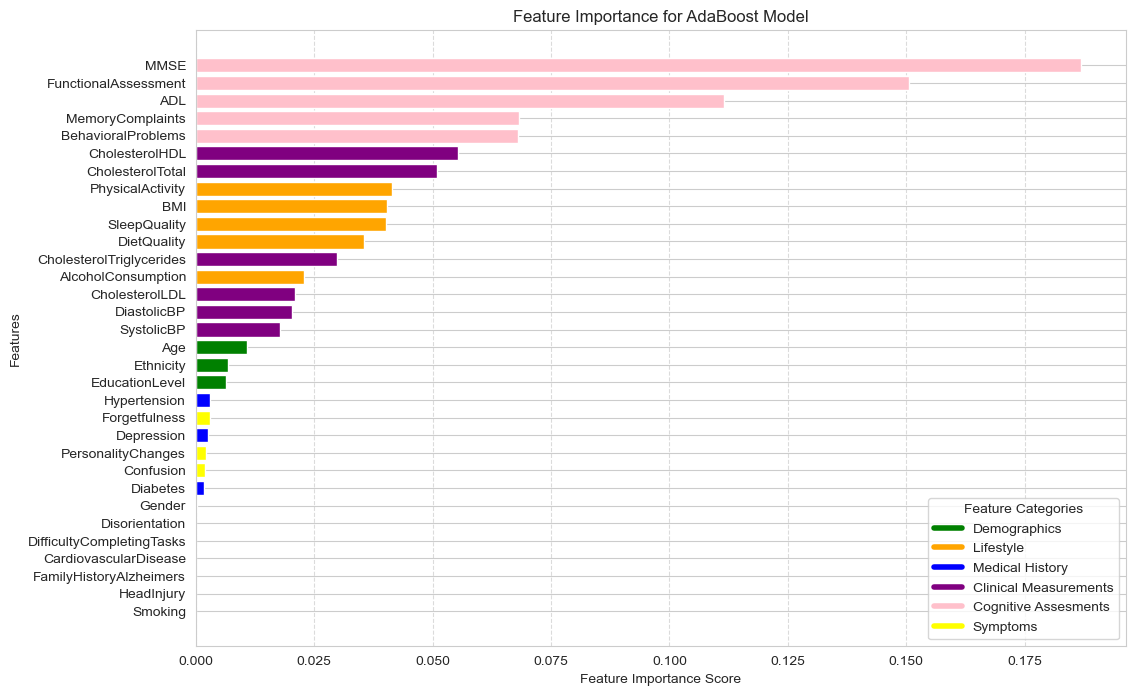

In [8]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, align='center', color=sorted_colors)
plt.title("Feature Importance for AdaBoost Model")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right', handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
for label, color in category_colors.items()],
               title="Feature Categories")
plt.show()

### **Feature Importance for Tuned XGBoost model**

In [9]:
# Best params from tuning
model_params = {
    'n_estimators': 602, 
    'learning_rate': 0.039830452299156896,
    'max_depth': 10, 
    'min_child_weight': 2, 
    'gamma': 3, 
    'subsample': 0.7828738024524255,
    'colsample_bytree': 0.6220394608069365,
    'reg_alpha': 0.8172447991553283, 
    'reg_lambda': 0.9181798354793087, 
    'scale_pos_weight': 4, 
    'eval_metric': 'error'
}

In [10]:
model1 = XGBClassifier(**model_params,random_state=123)
model1.fit(df_train[all_features[:-1]],df_train.Diagnosis)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6220394608069365, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.039830452299156896,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=602, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [11]:
#Compute feature important scores
importances = model1.feature_importances_
indices = np.flip(np.argsort(importances))

sorted_features = [all_features[i] for i in indices]  #features sorted in descending order according to importance
sorted_importances = importances[indices]  #importance scores sorted in descending order


# Assign colors to the features
sorted_colors = [
    category_colors.get(feature_categories.get(feature, "Symptoms"), "yellow")
    for feature in sorted_features
]

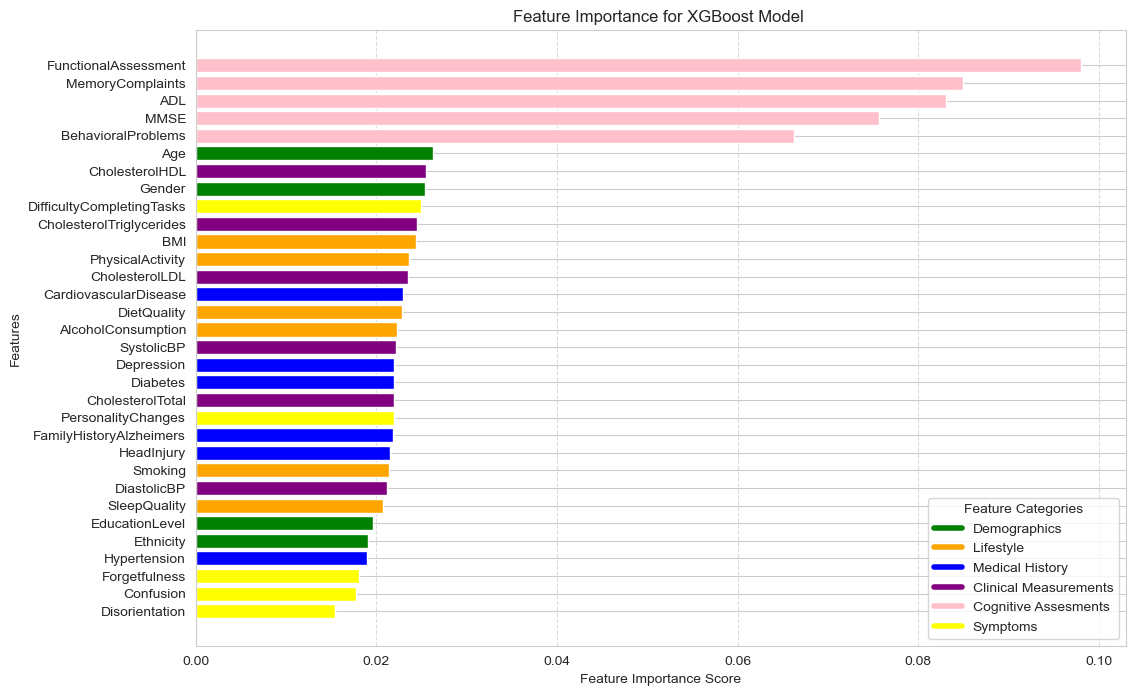

In [12]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, align='center', color=sorted_colors)
plt.title(f"Feature Importance for XGBoost Model ")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right', handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
for label, color in category_colors.items()],
               title="Feature Categories")
plt.show()